## Aviya Bilet narhlarini bashorat qiluvchi Model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, max_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pickle

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
!git clone https://github.com/Xbeck/Aviya-bilet-narxi.git

fatal: destination path 'Aviya-bilet-narxi' already exists and is not an empty directory.


In [ ]:
train_data = pd.read_csv('/content/Aviya-bilet-narxi/train_data.csv')

test_data = pd.read_csv('/content/Aviya-bilet-narxi/test_data.csv')

sample_solution = pd.read_csv('/content/Aviya-bilet-narxi/sample_solution.csv')

In [ ]:
train_data.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


In [ ]:
dict = {'zero': 0, 'one': 0.5, 'two_or_more': 1}
train_data['stops'] = train_data['stops'].map(dict)
test_data['stops'] = test_data['stops'].map(dict)

In [ ]:
dict = {'Economy': 0, 'Business': 1}
train_data['class'] = train_data['class'].map(dict)
test_data['class'] = test_data['class'].map(dict)
train_data.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,0.5,Night,Mumbai,0,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,0.0,Night,Kolkata,0,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,0.5,Evening,Delhi,1,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,0.5,Evening,Hyderabad,0,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,0.0,Morning,Mumbai,0,2.00,4,10712


In [ ]:
# Data setni qismlarga bo'lish
train_set, test_set = train_test_split(train_data, test_size=0.25, random_state=12)
train_set.shape, test_set.shape

((15000, 12), (5000, 12))

In [ ]:
# Raqamli va Matinli ustunlarni ajratish
X_train_num = train_set[['stops', 'class', 'duration']]
y_train = train_set['price'].copy()
X_train_cat = train_set.drop(['stops', 'class', 'duration', 'days_left', 'id', 'flight', 'arrival_time', 'departure_time', 'price'], axis=1)

X_test_num = test_set[['stops', 'class', 'duration']]
y_test = test_set['price'].copy()
X_test_cut = test_set.drop(['stops', 'class', 'duration', 'days_left', 'id', 'flight', 'arrival_time', 'departure_time'], axis=1)

In [ ]:
# Aviya bilet narxiga tasiri yo'q ustunlarni tashlab yuboramiz
train_set = train_set.drop(['days_left', 'id', 'flight', 'arrival_time', 'departure_time', 'price'], axis=1)
test_set = test_set.drop(['days_left', 'id', 'flight', 'arrival_time', 'departure_time', 'price'], axis=1)

In [ ]:
X_train_num.head()

,stops,class,duration
16416,0.5,1,8.00
3804,0.5,1,14.50
15177,0.5,1,8.75
15035,0.5,1,10.00
18136,0.0,0,1.17


In [ ]:
X_train_cat.head()

,airline,source_city,destination_city
16416,Vistara,Mumbai,Bangalore
3804,Vistara,Bangalore,Delhi
15177,Vistara,Hyderabad,Mumbai
15035,Vistara,Mumbai,Bangalore
18136,Indigo,Bangalore,Hyderabad


In [ ]:
X_train_cat['airline'].value_counts()

Vistara      6432
Air_India    4033
Indigo       2160
GO_FIRST     1130
AirAsia       790
SpiceJet      455
Name: airline, dtype: int64

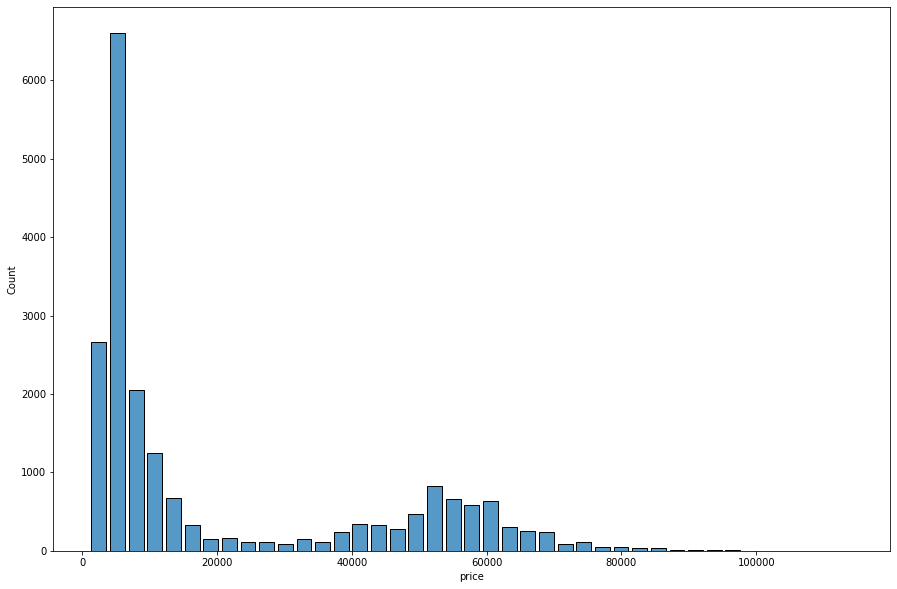

In [ ]:
# Vizualizatsiya
plt.figure(figsize=(15, 10))
sns.histplot(data=train_data, x=train_data['price'], shrink=.8)
plt.show()

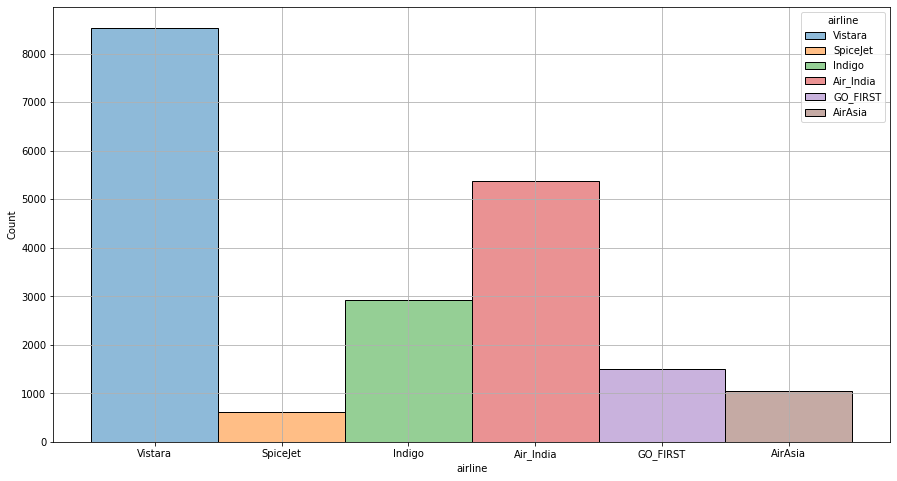

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(train_data, x="airline", hue="airline")
plt.grid()
plt.show()

In [ ]:
# Funksiya Pipline
def full_pipli(df_train, df_num, text_columns_list):

  # Raqamli ustunlar uchun
  num_pipline = Pipeline([
      ('std_scaler', StandardScaler())
    ])

  # Matinli ustunlar uchun
  num_attribs = list(df_num)    # list(X_train_num)
  cat_attribs = text_columns_list   #  ['airline', 'source_city', 'destination_city']

  # Barcha ustunlar uchun
  full_pipline = ColumnTransformer([
      ('num', num_pipline, num_attribs),
      ('cat', OrdinalEncoder(), cat_attribs),
    ])
  
  # Normallashtirish
  prepared = full_pipline.fit_transform(df_train)    # full_pipline.fit_transform(train_set)
  return prepared

In [ ]:
# Train set qiymatlarini narmallashtiramiz
text_columns_list = ['airline', 'source_city', 'destination_city']
x_train_prepared = full_pipli(train_set, X_train_num, text_columns_list)    # df_train = train_set, df_num = X_train_num

# Test set qiymatlarini narmallashtiramiz
x_test_prepared = full_pipli(test_set, X_test_num, text_columns_list)     # df_train = test_set, # df_num = X_test_num
x_train_prepared.shape, x_test_prepared.shape     # X_train_num, X_test.shape

((15000, 6), (5000, 6))

In [ ]:
def try_model(model):
  # Training
  model = model.fit(x_train_prepared, y_train)

  # Test
  y_pred = model.predict(x_test_prepared)

  # Model natijasi y_pred bilan to'g'ri javob y_test ni solishtiramiz
  print("MAE = ", np.around(mean_absolute_error(y_pred, y_test), 3))
  print('RMSE = ', np.around(np.sqrt(mean_squared_error(y_test, y_pred)), 3))
  print("MAX = ", np.around(max_error(y_pred, y_test), 3)) 
  print("R2_score = ", np.around(r2_score(y_pred, y_test), 3))    # modelni baholash, ball
  return model, y_pred

##Chiziqli regressiya modeli    -- LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

# # Modelni o'qitish
# LR_model = lr_model.fit(x_prepared, y_train)
# y_pred = LR_model.predict(X_test)
LR_model, y_pred_lr = try_model(lr_model)

# modelni saqlab olish
with open('LR_model.pkl','wb') as f:
    pickle.dump(LR_model, f)

MAE =  4778.298
RMSE =  7064.015
MAX =  41156.912
R2 =  0.894


## Logistic Regression modeli

In [ ]:
from sklearn.linear_model import LogisticRegression
logr_model = LogisticRegression(
                                  penalty='l2',
                                  tol=0.0001,
                                  fit_intercept=True,
                                  max_iter=1000
                                )

# modelni o'qitish
LogR_model, y_pred_logr = try_model(logr_model)

# modelni saqlab olish
with open('LogR_model.pkl','wb') as f:
    pickle.dump(LogR_model, f)

MAE =  3477.595
RMSE =  6083.315
MAX =  50858
R2 =  0.926


##Qaror daraxti regressori   -- DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(
                                  criterion='squared_error', splitter='best', 
                                  max_depth=20, 
                                  min_samples_split=2,
                                  random_state=12, 
                                  max_leaf_nodes=10
                                 )

# modelni o'qitish
DT_model, y_pred_dt = try_model(dt_model)

# modelni saqlab olish
with open('DT_model.pkl','wb') as f:
    pickle.dump(DT_model, f)

MAE =  3865.72
RMSE =  5737.704
MAX =  36790.171
R2 =  0.932


##Tasodifiy o'rmon regressori  -- RandomForestRegressor

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
                                  n_estimators=1000, 
                                  max_depth=20
                                )

# # modelni o'qitish
RF_model, y_pred_rt = try_model(rf_model)

# modelni saqlab olish
with open('RF_model.pkl','wb') as f:
    pickle.dump(RF_model, f)

MAE =  3298.027
RMSE =  5222.598
MAX =  36983.757
R2 =  0.945


##Ko'p qatlamli Perceptron regressori   -- MLPRegressor

In [56]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(
                        hidden_layer_sizes=(600, 60), activation='relu', solver='adam', 
                        alpha=0.1,
                        learning_rate_init=0.01, 
                        power_t=0.5, 
                        max_iter=20000, 
                        shuffle=True,
                        random_state=12, 
                        n_iter_no_change=120, 
                        max_fun=5000
                      )

# # modelni o'qitish
MLP_model, y_pred_mlp = try_model(mlp_model)

# modelni saqlab olish
with open('MLP_model.pkl','wb') as f:
    pickle.dump(MLP_model, f)


MAE =  3261.107
RMSE =  5017.133
MAX =  41848.418
R2 =  0.949


In [70]:
sample_solution['price'] = y_pred_rt
sample_solution

,price
id,
1,54862.052544
2,6633.719725
3,4094.075071
4,6670.800318
5,51392.065867
...,...
4996,9254.759860
4997,65969.340180
4998,22155.448000


In [ ]:
sample_solution.style.hide_index()